# Classification example: recognize handwritten digits

> This chapter is heavily inspired by the book [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) written by Aurélien Géron.

## Learning objectives

- Train a Machine Learning model on bitmap images.
- Understand how loss and model performance are evaluated in classification tasks.
- Discover several performance metrics and how to choose between them.

## Environment setup

In [48]:
# Relax some linting rules not needed here
# pylint: disable=invalid-name,wrong-import-position,redefined-outer-name

import platform

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

print(f"Python version: {platform.python_version()}")
print(f"NumPy version: {np.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")

Python version: 3.11.1
NumPy version: 1.26.3
scikit-learn version: 1.3.2


In [49]:
# sklearn does not automatically import its subpackages
# https://stackoverflow.com/a/9049246/2380880
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    RocCurveDisplay,
)
from sklearn.linear_model import SGDClassifier

In [50]:
# Setup plots

# Include matplotlib graphs into the notebook, next to the code
# https://stackoverflow.com/a/43028034/2380880
%matplotlib inline

# Improve plot quality
%config InlineBackend.figure_format = "retina"

# Setup seaborn default theme
# http://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme
sns.set_theme()

## Context and data preparation

### The MNIST handwritten digits dataset

This [dataset](http://yann.lecun.com/exdb/mnist/), a staple of Machine Learning and the "Hello, world!" of computer vision, contains 70,000 bitmap images of digits.

The associated target (expected result) for any image is the digit its represents.

In [51]:
# Load the MNIST digits dataset from sciki-learn
images, targets = fetch_openml(
    "mnist_784", version=1, parser="pandas", as_frame=False, return_X_y=True
)

print(f"Images: {images.shape}. Targets: {targets.shape}")
print(f"First 10 digits: {targets[:10]}")

Images: (70000, 784). Targets: (70000,)
First 10 digits: ['5' '0' '4' '1' '9' '2' '1' '3' '1' '4']


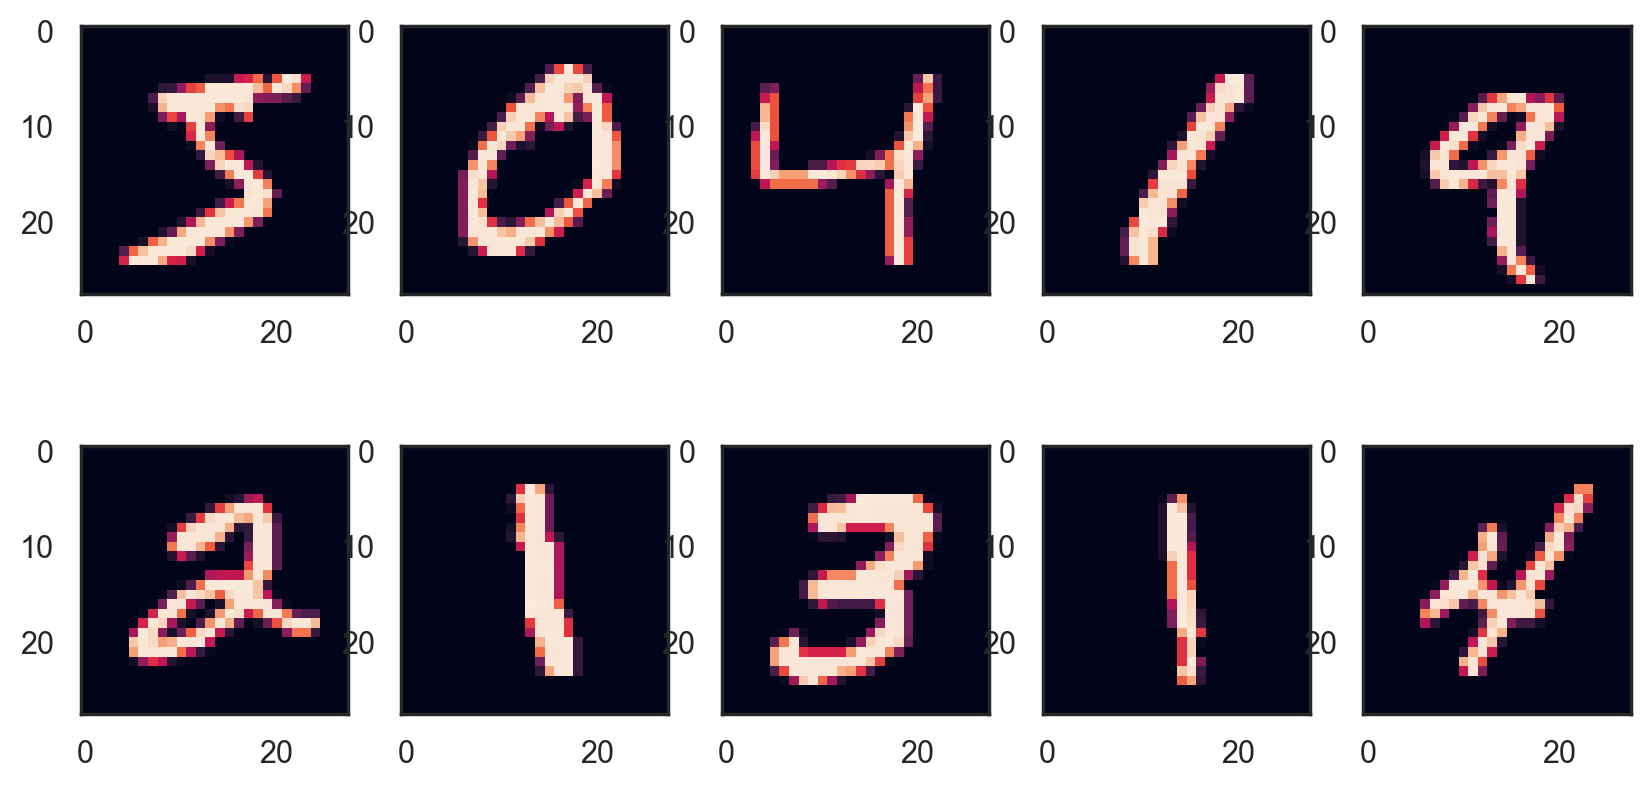

In [52]:
# Plot the first 10 digits

# Temporary hide Seaborn grid lines
with sns.axes_style("white"):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        digit = images[i].reshape(28, 28)
        fig = plt.subplot(2, 5, i + 1)
        plt.imshow(digit)

### Training and test sets

Data preparation begins with splitting the dataset between training and test sets.

In [53]:
# Split dataset into training and test sets
train_images, test_images, train_targets, test_targets = train_test_split(
    images, targets, test_size=10000
)

print(f"Training images: {train_images.shape}. Training targets: {train_targets.shape}")
print(f"Test images: {test_images.shape}. Test targets: {test_targets.shape}")

Training images: (60000, 784). Training targets: (60000,)
Test images: (10000, 784). Test targets: (10000,)


### Images rescaling

For grayscale bitmap images, each pixel value is an integer between $0$ and $255$.

Next, we need to rescale pixel values into the $[0,1]$ range. The easiest way is to divide each value by $255.0$.

In [54]:
# Rescale pixel values from [0,255] to [0,1]
x_train, x_test = train_images / 255.0, test_images / 255.0

print(f"x_train: {x_train.shape}")
print(f"x_test: {x_train.shape}")

x_train: (60000, 784)
x_test: (60000, 784)


## Binary classification

### Creating binary targets

To simplify things, let's start by trying to identify one digit: the number 5. The problem is now a **binary classification** task.

In [55]:
# Transform results into binary values
# label is true for all 5s, false for all other digits
y_train_5 = train_targets == "5"
y_test_5 = train_targets == "5"

print(train_targets[:10])
print(y_train_5[:10])

['8' '8' '2' '6' '3' '0' '8' '3' '2' '9']
[False False False False False False False False False False]


### Choosing a loss function

This choice depends on the problem type. For binary classification tasks where expected results are either 1 (*True*) or 0 (*False*), a popular choice is the **Binary CrossEntropy**, a.k.a **logistic loss** or **log loss**.

$$\mathcal{L}_{\mathrm{BCE}}(\pmb{\omega}) = -\frac{1}{m}\sum_{i=1}^m \left(y^{(i)} \log_e(y'^{(i)}) + (1-y^{(i)}) \log_e(1-y'^{(i)})\right)$$

- $y^{(i)} \in \{0,1\}$: expected result for the $i$th sample.
- $y'^{(i)} = h_{\pmb{\omega}}(\pmb{x}^{(i)}) \in [0,1]$: model output for the $i$th sample.

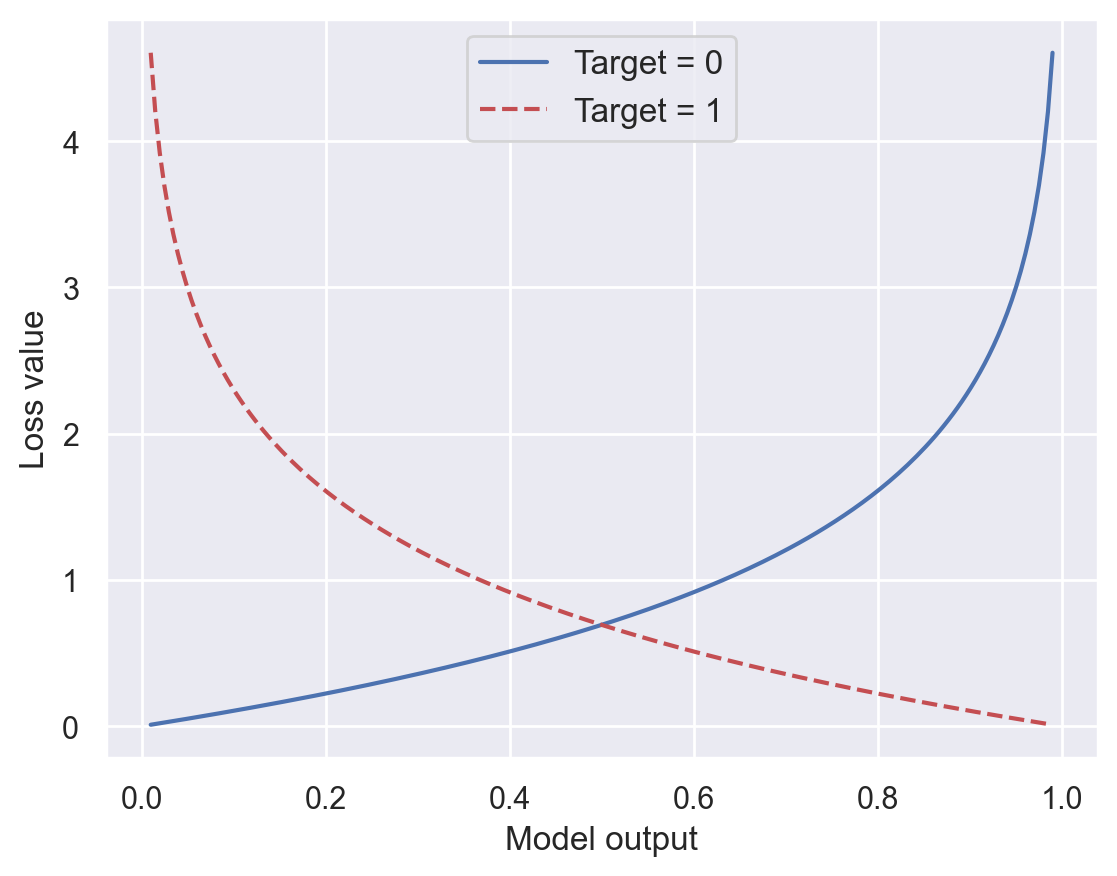

In [56]:
# Plot logistic loss for one output
x = np.linspace(0.01, 0.99, 200)
plt.plot(x, -np.log(1 - x), label="Target = 0")
plt.plot(x, -np.log(x), "r--", label="Target = 1")
plt.xlabel("Model output")
plt.ylabel("Loss value")
plt.legend(fontsize=12)
plt.show()

### Training a binary classifier

In [57]:
# Create a classifier using stochastic gradient descent and logistic loss
sgd_model = SGDClassifier(loss="log_loss")

# Train the model on data
sgd_model.fit(x_train, y_train_5)

SGDClassifier(loss='log_loss')

### Assesing  performance

#### Thresholding model output

A ML model computes probabilities (or scores that are transformed into probabilities). These decimal values are *thresholded* into discrete values to form the model's prediction.

In [58]:
# Check model predictions for the first 10 training samples

samples = x_train[:10]

# Print binary predictions ("is the digit a 5 or not?")
print(sgd_model.predict(samples))

# Print prediction probabilities
sgd_model.predict_proba(samples).round(decimals=3)

[False False False False  True False False False False False]


array([[0.747, 0.253],
       [0.926, 0.074],
       [1.   , 0.   ],
       [0.997, 0.003],
       [0.343, 0.657],
       [0.859, 0.141],
       [0.971, 0.029],
       [0.849, 0.151],
       [1.   , 0.   ],
       [1.   , 0.   ]])

#### Accuracy

The default performance metric for classification taks is **accuracy**.

$$Accuracy = \frac{\text{Number of exact predictions}}{\text{Total number of predictions}} $$

In [59]:
# Define fictitious ground truth and prediction results
y_true = np.array([1, 0, 0, 1, 1, 1])
y_pred = np.array([1, 1, 0, 1, 0, 1])

# Compute accuracy: 4/6 = 2/3
acc = np.sum(y_pred == y_true) / len(y_true)
print(f"{acc:.2f}")

0.67


##### Computing training accuracy

In [60]:
# The score function computes accuracy of the SGDClassifier
train_acc = sgd_model.score(x_train, y_train_5)
print(f"Training accuracy: {train_acc:.05f}")

# Using cross-validation to better evaluate accuracy, using 3 folds
cv_acc = cross_val_score(sgd_model, x_train, y_train_5, cv=3, scoring="accuracy")
print(f"Cross-validation accuracy: {cv_acc}")

Training accuracy: 0.97383
Cross-validation accuracy: [0.9734  0.9719  0.97255]


##### Accuracy shortcomings

When the dataset is *skewed* (some classes are more frequent than others), computing accuracy is not enough to assert the model's performance.

To find out why, let's imagine a dumb binary classifier that always predicts that the digit is not 5.

In [61]:
# Count the number of non-5 digits in the dataset
not5_count = len(y_train_5) - np.sum(y_train_5)
print(f"There are {not5_count} digits other than 5 in the training set")

dumb_model_acc = not5_count / len(x_train)
print(f"Dumb classifier accuracy: {dumb_model_acc:.05f}")

There are 54598 digits other than 5 in the training set
Dumb classifier accuracy: 0.90997


#### True/False positives and negatives

- **True Positive (TP)**: the model _correctly_ predicts the positive class.
- **False Positive (FP)**: the model _incorrectly_ predicts the positive class.
- **True Negative (TN)**: the model _correctly_ predicts the negative class.
- **False Negative (FN)**: the model _incorrectly_ predicts the negative class.

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

#### Confusion matrix

Useful representation of classification results. Row are actual classes, columns are predicted classes.

[![Confusion matrix for 5s](_images/confusion_matrix.png)](https://github.com/ageron/handson-ml2)

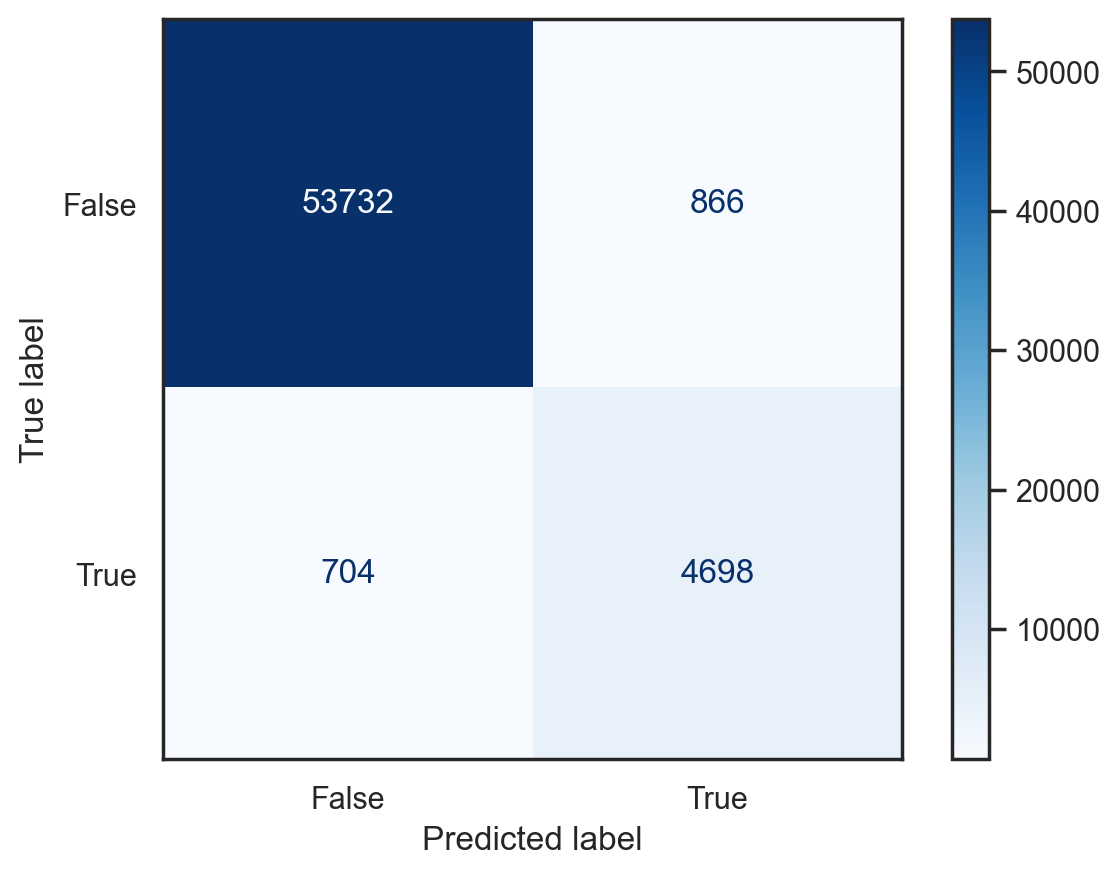

In [62]:
def plot_conf_mat(model, x, y):
    """Plot the confusion matrix for a model, inputs and targets"""

    with sns.axes_style("white"):  # Temporary hide Seaborn grid lines
        _ = ConfusionMatrixDisplay.from_estimator(
            model, x, y, values_format="d", cmap=plt.colormaps.get_cmap("Blues")
        )


# Plot confusion matrix for the SGDClassifier
plot_conf_mat(sgd_model, x_train, y_train_5)

#### Precision and recall

- **Precision**: proportion of positive identifications that were actually correct.
- **Recall** (or *sensitivity*): proportion of actual positives that were identified correctly.

$$Precision = \frac{TP}{TP + FP} = \frac{\text{True Positives}}{\text{Total Predicted Positives}}$$

$$Recall = \frac{TP}{TP + FN} = \frac{\text{True Positives}}{\text{Total Actual Positives}}$$

In [63]:
# Define fictitious ground truth and prediction results
y_true = np.array([1, 0, 0, 1, 1, 1])
y_pred = np.array([1, 1, 0, 1, 0, 0])

# Compute precision and recall for both classes
for label in [0, 1]:
    TP = np.sum((y_pred == label) & (y_true == label))
    FP = np.sum((y_pred == label) & (y_true == 1 - label))
    FN = np.sum((y_pred == 1 - label) & (y_true == label))
    print(f"Class {label}: Precision {TP/(TP+FP):.02f}, Recall {TP/(TP+FN):.02f}")

Class 0: Precision 0.33, Recall 0.50
Class 1: Precision 0.67, Recall 0.50


##### Example: a (flawed) tumor classifier

Context: binary classification of tumors (positive means malignant). Dataset of 100 tumors, of which 9 are malignant.

| Negatives | Positives |
|-|-|
| True Negatives: 90 | False Positives: 1 |
| False Negatives: 8 | True Positives: 1|

$$Accuracy = \frac{90+1}{100} = 91\%$$

$$Precision = \frac{1}{1 + 1} = 50\%\;\;\;
Recall = \frac{1}{1 + 8} = 11\%$$

##### The precision/recall trade-off

- Improving precision typically reduces recall and vice versa ([example](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall#precision-and-recall:-a-tug-of-war)).
- Precision matters most when the cost of false positives is high (example: spam detection).
- Recall matters most when the cost of false negatives is high (example: tumor detection).

#### F1 score

- Weighted average (*harmonic mean*) of precision and recall.
- Also known as _balanced F-score_ or _F-measure_.
- Favors classifiers that have similar precision and recall.

$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

In [64]:
# Compute several metrics about the SGDClassifier
print(classification_report(y_train_5, sgd_model.predict(x_train)))

              precision    recall  f1-score   support

       False       0.99      0.98      0.99     54598
        True       0.84      0.87      0.86      5402

    accuracy                           0.97     60000
   macro avg       0.92      0.93      0.92     60000
weighted avg       0.97      0.97      0.97     60000



#### ROC curve and AUROC

$$\text{TP Rate} = \frac{TP}{TP + FN} = Recall\;\;\;\;
\text{FP Rate} = \frac{FP}{FP + TN}$$

- ROC stands for "Receiver Operating Characteristic".
- A ROC curve plots TPR vs. FPR at different classification thresholds.
- AUC or more precisely AUROC ("Area Under the ROC Curve") provides an aggregate measure of performance across all possible classification thresholds.

[![AUROC animation](_images/auroc_animation.gif)](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation)

[![AUROC shape animation](_images/auroc_shape_animation.gif)](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation)

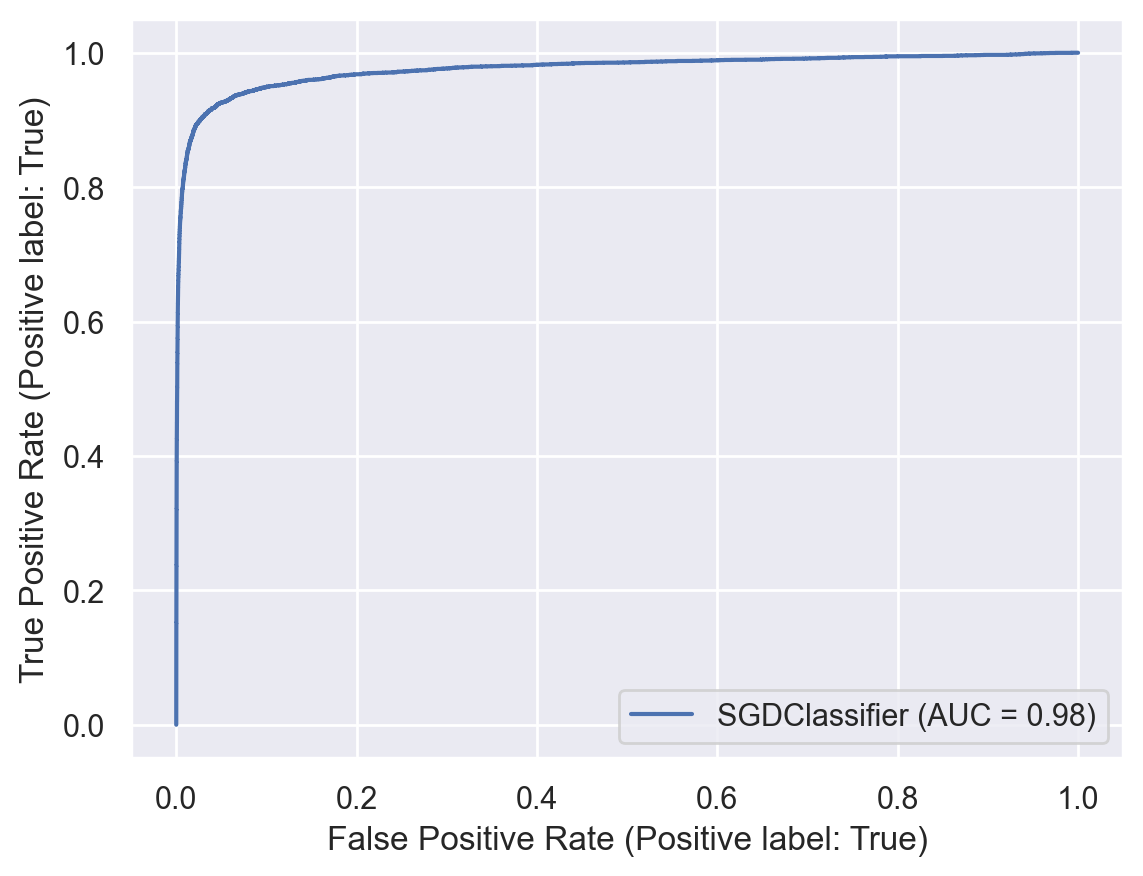

In [65]:
# Plot ROC curve for the SGDClassifier
sgd_disp = RocCurveDisplay.from_estimator(sgd_model, x_train, y_train_5)
plt.show()

## Multiclass classification

### Choosing a loss function

The **Categorical Cross-Entropy** is the loss function of choice for multiclass classfication. When $K=2$, it is equivalent to binary cross-entropy.

$$\mathcal{L}_{\mathrm{CCE}}(\pmb{\omega}) = -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K y^{(i)}_k \log_e(y'^{(i)}_k))$$

- $y^{(i)}_k \in \{0,1\}$: expected value for the $k$th label of the $i$th sample.
- $y'^{(i)}_k \in [0,1]$: model output for the $k$th label of the $i$th sample.

### Training a multiclass classifier

In [69]:
# Using all digits as training results
y_train = train_targets
y_test = test_targets

# Training another SGD classifier to recognize all digits
multi_sgd_model = SGDClassifier(loss="log_loss")
multi_sgd_model.fit(x_train, y_train)

SGDClassifier(loss='log_loss')

### Assessing performance

In [70]:
# Since dataset is not class imbalanced anymore, accuracy is now a reliable metric
print(f"Training accuracy: {multi_sgd_model.score(x_train, y_train):.05f}")
print(f"Test accuracy: {multi_sgd_model.score(x_test, y_test):.05f}")

Training accuracy: 0.92108
Test accuracy: 0.91410


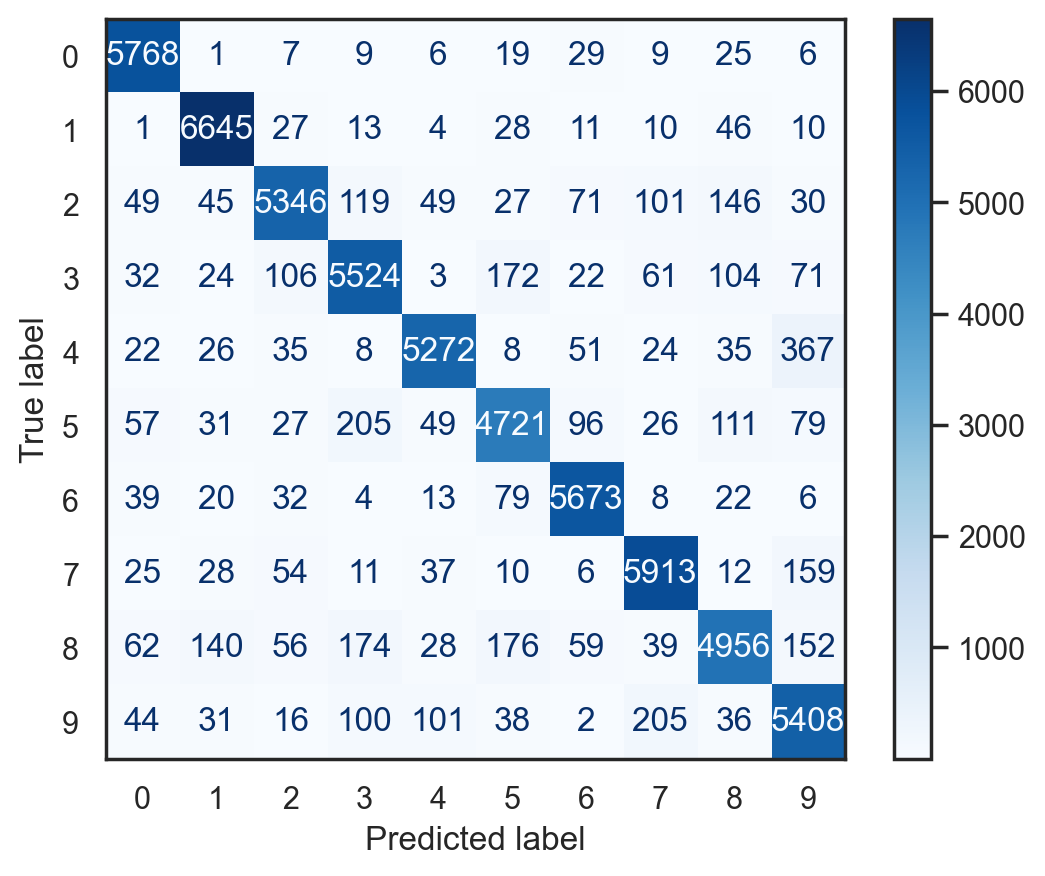

In [67]:
# Plot confusion matrix for the multiclass SGD classifier
plot_conf_mat(multi_sgd_model, x_train, y_train)

In [68]:
# Compute performance metrics about the multiclass SGD classifier
print(classification_report(y_train, multi_sgd_model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      5879
           1       0.95      0.98      0.96      6795
           2       0.94      0.89      0.91      5983
           3       0.90      0.90      0.90      6119
           4       0.95      0.90      0.92      5848
           5       0.89      0.87      0.88      5402
           6       0.94      0.96      0.95      5896
           7       0.92      0.95      0.93      6255
           8       0.90      0.85      0.87      5842
           9       0.86      0.90      0.88      5981

    accuracy                           0.92     60000
   macro avg       0.92      0.92      0.92     60000
weighted avg       0.92      0.92      0.92     60000

